https://allensdk.readthedocs.io/en/latest/_static/examples/nb/mouse_connectivity.html

In [1]:
import os, sys, time, glob, json, math, warnings, csv
import tifffile as tif
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
import numpy as np
import pandas as pd
import scipy.spatial.distance as spd
import scipy.cluster as scc
import scipy.cluster.hierarchy as shc
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet, fcluster
from sklearn.cluster import AgglomerativeClustering
import scipy
from scipy.spatial.distance import pdist
from scipy.ndimage.interpolation import zoom

from allensdk.core.mouse_connectivity_cache import MouseConnectivityCache
from allensdk.api.queries.ontologies_api import OntologiesApi

from itertools import chain

In [2]:
# location of your repo clone
sys.path.append("../../..")

In [3]:
# base path
src = "/home/emilyjanedennis/Desktop/"

In [4]:
def get_dists(val,list_of_vals):
    dists = []
    for comp_val in list_of_vals:
        dists.append(math.dist(val,comp_val))
    return dists

In [5]:
def make_heatmap(matrix):
    fig, ax = plt.subplots(figsize=(100,30))
    heatmap = ax.pcolor(matrix, cmap=plt.cm.bone_r)

    # put the major ticks at the middle of each cell
    ax.set_xticks(np.arange(matrix.shape[1])+0.5, minor=False)
    ax.set_yticks(np.arange(matrix.shape[0])+0.5, minor=False)

    ax.set_xlim([0, matrix.shape[1]])
    ax.set_ylim([0, matrix.shape[0]])          

    # want a more natural, table-like display
    ax.invert_yaxis()
    ax.xaxis.tick_top()
    return fig, ax

## 2021.08.03

In [6]:
mcc = MouseConnectivityCache(manifest_file='connectivity/mouse_connectivity_manifest.json')
all_experiments = mcc.get_experiments(dataframe=True)
print("%d total experiments" % len(all_experiments))


2992 total experiments


In [7]:
all_experiments.loc[122642490]

gender                                            M
injection_structures                     [985, 993]
injection_volume                           0.151071
injection_x                                    4300
injection_y                                    2690
injection_z                                    7050
product_id                                        5
specimen_name                          Syt6-Cre-585
strain                                     C57BL/6J
structure_abbrev                                MOs
structure_id                                    993
structure_name                 Secondary motor area
transgenic_line                      Syt6-Cre_KI148
transgenic_line_id                      1.77839e+08
id                                        122642490
primary_injection_structure                     985
Name: 122642490, dtype: object

In [8]:
# grab the StructureTree instance
structure_tree = mcc.get_structure_tree()

# get info on some structures
structures = structure_tree.get_structures_by_name(['Primary visual area', 'Hypothalamus'])
pd.DataFrame(structures)

oapi = OntologiesApi()

# get the ids of all the structure sets in the tree
structure_set_ids = structure_tree.get_structure_sets()

# query the API for information on those structure sets
pd.DataFrame(oapi.get_structure_sets(structure_set_ids))

,description,id,name
0,List of structures in Isocortex layer 5,667481446,Isocortex layer 5
1,List of structures in Isocortex layer 6b,667481450,Isocortex layer 6b
2,Summary structures of the cerebellum,688152368,Cerebellum
3,List of structures for ABA Differential Search,12,ABA - Differential Search
4,List of valid structures for projection target...,184527634,Mouse Connectivity - Target Search
5,Structures whose surfaces are represented by a...,691663206,Mouse Brain - Has Surface Mesh
6,Summary structures of the midbrain,688152365,Midbrain
7,Summary structures of the medulla,688152367,Medulla
8,Summary structures of the striatum,688152361,Striatum
9,Structures representing subdivisions of the mo...,687527945,Mouse Connectivity - Summary


In [9]:
#from the above table, we want regions valid for target search
summary_structures=pd.DataFrame(structure_tree.get_structures_by_set_id([184527634])) #set id == fo target search
summary_structures

,acronym,graph_id,graph_order,id,name,structure_id_path,structure_set_ids,rgb_triplet
0,grey,1,1,8,Basic cell groups and regions,"[997, 8]","[112905828, 691663206, 12, 184527634, 11290581...","[191, 218, 227]"
1,CH,1,2,567,Cerebrum,"[997, 8, 567]","[112905828, 691663206, 12, 184527634, 11290581...","[176, 240, 255]"
2,CTX,1,3,688,Cerebral cortex,"[997, 8, 567, 688]","[112905828, 691663206, 12, 184527634, 11290581...","[176, 255, 184]"
3,CTXpl,1,4,695,Cortical plate,"[997, 8, 567, 688, 695]","[112905828, 691663206, 12, 184527634, 11290581...","[112, 255, 112]"
4,Isocortex,1,5,315,Isocortex,"[997, 8, 567, 688, 695, 315]","[2, 112905828, 691663206, 12, 184527634, 11290...","[112, 255, 113]"
...,...,...,...,...,...,...,...,...
835,sm,1,1285,802,stria medullaris,"[997, 1009, 991, 824, 1083, 802]","[184527634, 691663206]","[204, 204, 204]"
836,fr,1,1286,595,fasciculus retroflexus,"[997, 1009, 991, 824, 1083, 595]","[184527634, 691663206]","[204, 204, 204]"
837,hbc,1,1287,611,habenular commissure,"[997, 1009, 991, 824, 1083, 611]","[184527634, 691663206]","[204, 204, 204]"
838,SEZ,1,1295,98,subependymal zone,"[997, 73, 81, 98]","[10, 184527634, 691663206]","[170, 170, 170]"


In [10]:
# find wild-type injections
allen_experiments = mcc.get_experiments(dataframe=True, cre=False, 
                                       injection_structure_ids=summary_structures['id'].tolist())
blk_six = allen_experiments[allen_experiments['strain']=='C57BL/6J']

print("%d allen experiments" % len(allen_experiments))
print("%d blk_six experiments" % len(blk_six))

structure_unionizes = mcc.get_structure_unionizes([ int(e) for e in blk_six['id'] ], 
                                                  is_injection=False,
                                                  structure_ids=summary_structures['id'].tolist(),
                                                  include_descendants=True)

print("%d wt non-injection, structure unionizes" % len(structure_unionizes))


498 allen experiments
498 blk_six experiments
1242520 wt non-injection, structure unionizes


In [11]:
experiment_ids = [ e for e in blk_six['id'].to_list() ]
ctx_children = structure_tree.descendant_ids( summary_structures['id'] )
ctx_children

[[8,
  567,
  688,
  695,
  315,
  184,
  68,
  667,
  526157192,
  526157196,
  526322264,
  500,
  107,
  219,
  299,
  644,
  947,
  985,
  320,
  943,
  648,
  844,
  882,
  993,
  656,
  962,
  767,
  1021,
  1085,
  453,
  12993,
  12994,
  12995,
  12996,
  12997,
  12998,
  322,
  793,
  346,
  865,
  921,
  686,
  719,
  353,
  558,
  838,
  654,
  702,
  889,
  929,
  329,
  981,
  201,
  1047,
  1070,
  1038,
  1062,
  480149202,
  480149206,
  480149210,
  480149214,
  480149218,
  480149222,
  480149226,
  337,
  1030,
  113,
  1094,
  1128,
  478,
  510,
  345,
  878,
  657,
  950,
  974,
  1102,
  2,
  369,
  450,
  854,
  577,
  625,
  945,
  1026,
  361,
  1006,
  670,
  1086,
  1111,
  9,
  461,
  182305689,
  182305693,
  182305697,
  182305701,
  182305705,
  182305709,
  182305713,
  378,
  873,
  806,
  1035,
  1090,
  862,
  893,
  1057,
  36,
  180,
  148,
  187,
  638,
  662,
  677,
  897,
  1106,
  1010,
  1058,
  857,
  849,
  247,
  1011,
  527,
  600,
  678

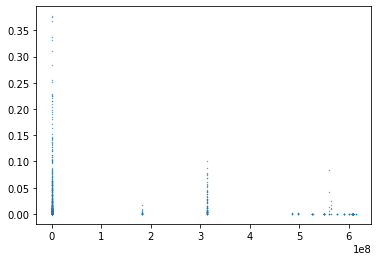

In [12]:
pm = mcc.get_projection_matrix(experiment_ids = experiment_ids, 
                               projection_structure_ids = ctx_children[0],
                               parameter = 'projection_density')


row_labels = pm['rows'] # these are just experiment ids
column_labels = [ c['structure_id'] for c in pm['columns'] ] 
matrix = pm['matrix']


row = 401
exp_name = pm['rows'][row]
values=pm['matrix'][row]
struct_ids = pm['columns']
ids=[struct['structure_id'] for struct in struct_ids]
plt.scatter(ids,values,s=.1)

# get PMA file, check for IDs there
## if any are missing, fill them in manually using below search


In [13]:
pma = pd.read_csv('/home/emilyjanedennis/Desktop/for_registration_to_lightsheet/labels/PMA_in_PRA.csv')

chk=[]
for i in ids:
    if i not in pma.ID.tolist():
        chk.append(i)

np.unique(chk)

array([], dtype=float64)

In [14]:
# if there's any missing, you'll need to manually add them to the atlas labels and re-import
pma = pd.read_csv('/home/emilyjanedennis/Desktop/for_registration_to_lightsheet/labels/PMA_in_PRA.csv')
# first, let's find them
if len(chk) > 0:
    for i in summary_structures.acronym.tolist():
        if i in np.unique(chk):
            print(summary_structures[summary_structures.acronym==i])
    for i in np.unique(chk):
        print(i)
        print(summary_structures[summary_structures.id==i]['name'])
        print(summary_structures[summary_structures.id==i]['acronym'])
# next, manually add these to your file, and re-import by re-running the cell


In [15]:
# ok great, now we have all our IDs are in PMA
# this means we have them in PRA as well
# let's plot by PRA values

pras=[]
prastruct=[]
for i in ids:
    if i in pma.ID.tolist():
        pras.append(pma[pma.ID==i]['praid'].tolist()[0])
        prastruct.append(pma[pma.ID==i]['structure_id_path'].tolist()[0])
    else:
        pras.append(-100)
        prastruct.append('-100')
        print(i)

prastruct

['/0/1',
 '/0/37',
 '/0/37/59',
 '/0/37/59',
 '/0/37/59',
 '/0/37/59/93',
 '/0/37/59/93',
 '/0/37/59/93',
 '/0/37/59/93',
 '/0/37/59/93',
 '/0/37/59/93',
 '/0/37/59/238',
 '/0/37/59/238',
 '/0/37/59/238',
 '/0/37/59/238',
 '/0/37/59/238',
 '/0/37/59/238',
 '/0/37/59/238/463',
 '/0/37/59/238/463',
 '/0/37/59/238/463',
 '/0/37/59/238/463',
 '/0/37/59/238/463',
 '/0/37/59/238/463',
 '/0/37/59/238/464',
 '/0/37/59/238/464',
 '/0/37/59/238/464',
 '/0/37/59/238/464',
 '/0/37/59/238/464',
 '/0/37/59/238/464',
 '/0/37/59/242',
 '/0/37/59/242',
 '/0/37/59/242',
 '/0/37/59/242',
 '/0/37/59/242',
 '/0/37/59/242',
 '/0/37/59/242',
 '/0/37/59/242/96',
 '/0/37/59/242/96',
 '/0/37/59/242/96',
 '/0/37/59/242/96',
 '/0/37/59/242/96',
 '/0/37/59/242/96',
 '/0/37/59/242/96',
 '/0/37/59/242/96',
 '/0/37/59/242/96',
 '/0/37/59/242/96',
 '/0/37/59/242/96',
 '/0/37/59/242/96',
 '/0/37/59/242/96',
 '/0/37/59/242/96',
 '/0/37/59/242/96',
 '/0/37/59/242/96',
 '/0/37/59/242/96',
 '/0/37/59/242/96',
 '/0/37/59/24

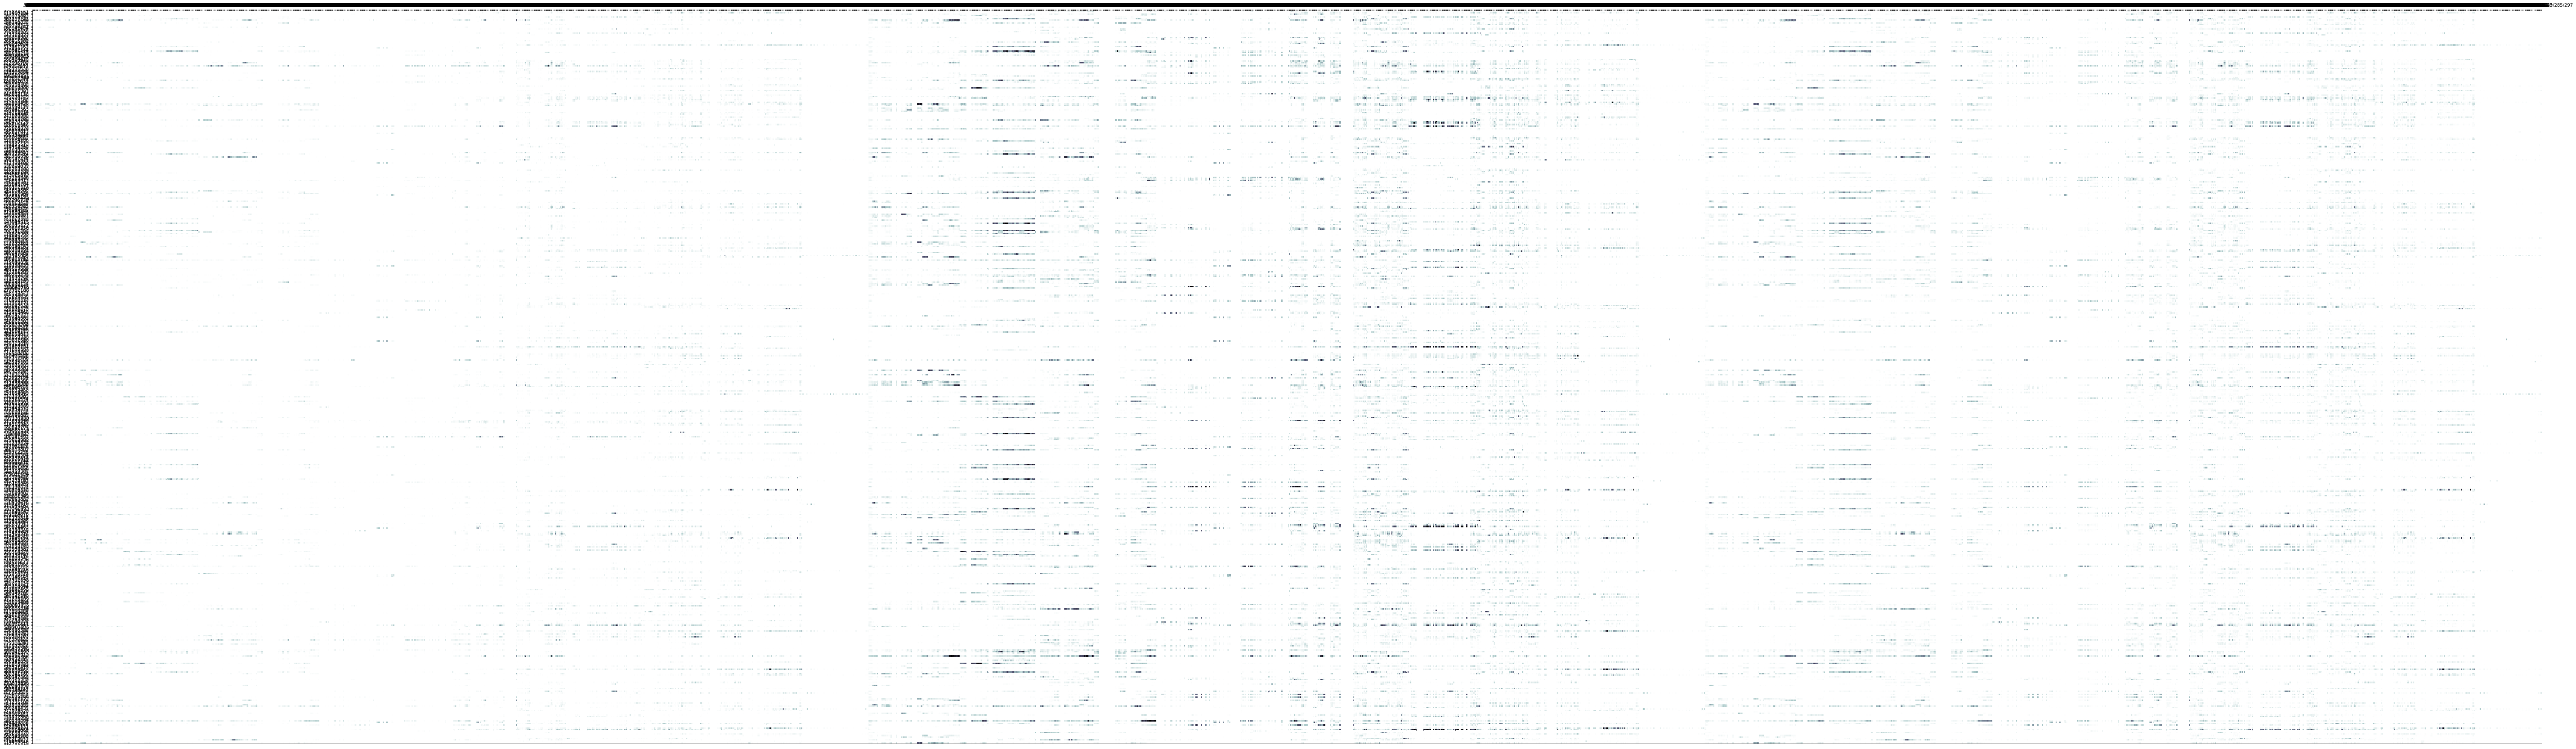

In [16]:
row_labels = pm['rows'] # these are just experiment ids
matrix = pm['matrix']
np.shape(matrix)

column_labels = [ c['structure_id'] for c in pm['columns'] ] 
np.shape(column_labels)
    
pras=[]
prastruct=[]
for i in column_labels:
    if i in pma.ID.tolist():
        pras.append(pma[pma.ID==i]['praid'].tolist()[0])
        prastruct.append(pma[pma.ID==i]['structure_id_path'].tolist()[0])
    else:
        pras.append(-100)
        prastruct.append('-100')
        print(i)

fig, ax = plt.subplots(figsize=(100,30))
heatmap = ax.pcolor(matrix, cmap=plt.cm.bone_r)

# put the major ticks at the middle of each cell
ax.set_xticks(np.arange(matrix.shape[1])+0.5, minor=False)
ax.set_yticks(np.arange(matrix.shape[0])+0.5, minor=False)

ax.set_xlim([0, matrix.shape[1]])
ax.set_ylim([0, matrix.shape[0]])          

# want a more natural, table-like display
ax.invert_yaxis()
ax.xaxis.tick_top()

ax.set_xticklabels(prastruct, minor=False)
ax.set_yticklabels(row_labels, minor=False)
plt.show()

# now let's cluster these experiments based on PRA label region expression!

(0.0, 1.0)

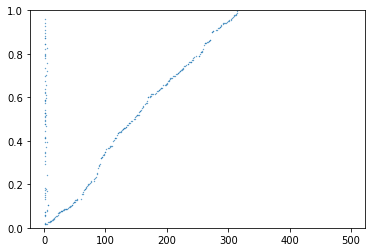

In [16]:
# remove nans
matrix_no_nans=(np.nan_to_num(matrix))

# get linkage
linked=linkage(matrix_no_nans,'single')

# how many clusters? there are lots of ways to think about this, here's one
X=matrix_no_nans.copy()
Z = linked.copy()
c, coph_dists = cophenet(Z, pdist(X))

zz = [z[2] for z in Z]
xx= [z[3] for z in Z]

plt.scatter(xx,zz,s=.1)
plt.ylim([0,1])


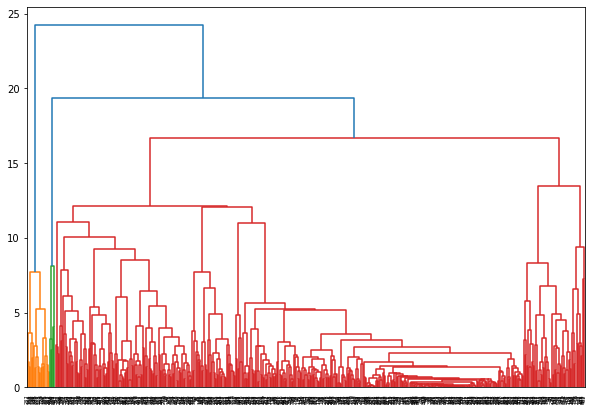

In [17]:
plt.figure(figsize=(10,7))
dend=shc.dendrogram(shc.linkage(matrix_no_nans,method='ward'))

### borrowed ideas from 
https://stackabuse.com/hierarchical-clustering-with-python-and-scikit-learn

In [18]:
norm_arr = []
for val in matrix_no_nans:
    norm_arr.append(val/(np.max(val)))

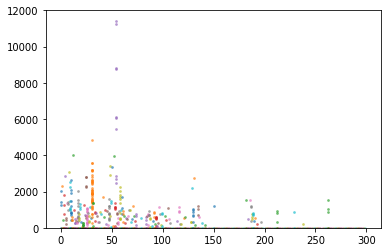

In [19]:
cluster = AgglomerativeClustering(n_clusters=300, affinity='euclidean', linkage='ward')
norm_arr_cluster_ids=cluster.fit_predict(norm_arr)
sort_indices_for_norm_arr=np.argsort(norm_arr_cluster_ids)


cluster_dict={}
for i in np.unique(norm_arr_cluster_ids):
    # for each unique cluster, find dists
    cluster_vals=[]
    cluster_dists=[]
    # get the exp_id for all cluster members, and use it to get injection position
    for exp_id in np.asarray(row_labels)[norm_arr_cluster_ids==i]:
        cluster_vals.append([blk_six[blk_six.id==exp_id]['injection_x'].tolist()[0], blk_six[blk_six.id==exp_id]['injection_y'].tolist()[0],blk_six[blk_six.id==exp_id]['injection_z'].tolist()[0]])
    # for each injection position, get the distances to all other cluster members
    for val in cluster_vals:
        cluster_dists.append(get_dists(val,cluster_vals))
    # make all injection positions into a single list, and add to dict
    cluster_dists=list(chain.from_iterable(cluster_dists))
    cluster_dict[str(i)]=cluster_dists

for i in cluster_dict:
    plt.scatter(int(i)*np.ones(len(cluster_dict[str(i)])),cluster_dict[str(i)],alpha=0.3,s=3)
    plt.ylim([0,12000])
plt.show()

# find closest match(es)
first, using the Allen data set, as a proof of concept take a random experiment's expression and find its closest matches. The #1 best match should be itself

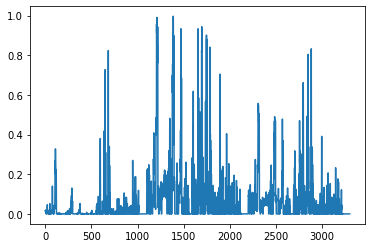

In [22]:
# get a single experiment
vect=matrix_no_nans[np.random.randint(len(matrix))]
plt.plot(vect)

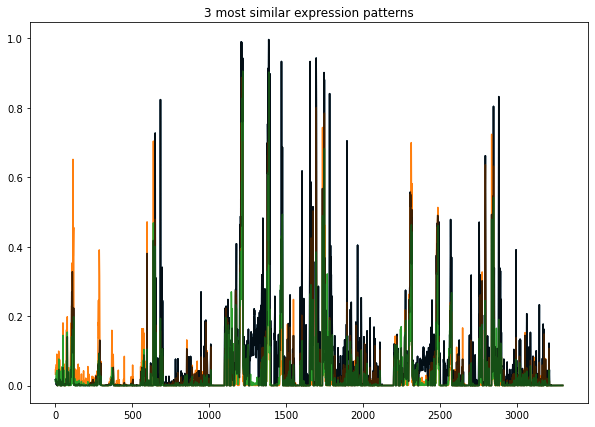

In [23]:
# find most similar vector(s)
#cosine similarity
list_of_cosines=[]
for val in matrix_no_nans:
    list_of_cosines.append(spd.cosine(vect,val))
cosine_sorted_indices = np.argsort(list_of_cosines)
cosine_sorted = list_of_cosines.copy()
cosine_sorted.sort()
num_cosines_to_plot = np.sum([np.array(cosine_sorted) < 0.2])

# plot
cosine_to_plot = matrix_no_nans[cosine_sorted_indices[0:num_cosines_to_plot]]
if num_cosines_to_plot < 2:
    num_cosines_to_plot=2
plt.figure(figsize=(10,7))
for i in np.arange(0,num_cosines_to_plot):
    plt.plot(cosine_to_plot[i])
    plt.plot(vect,'k',alpha=0.5)
plt.title('{} most similar expression patterns'.format(num_cosines_to_plot))
plt.show()


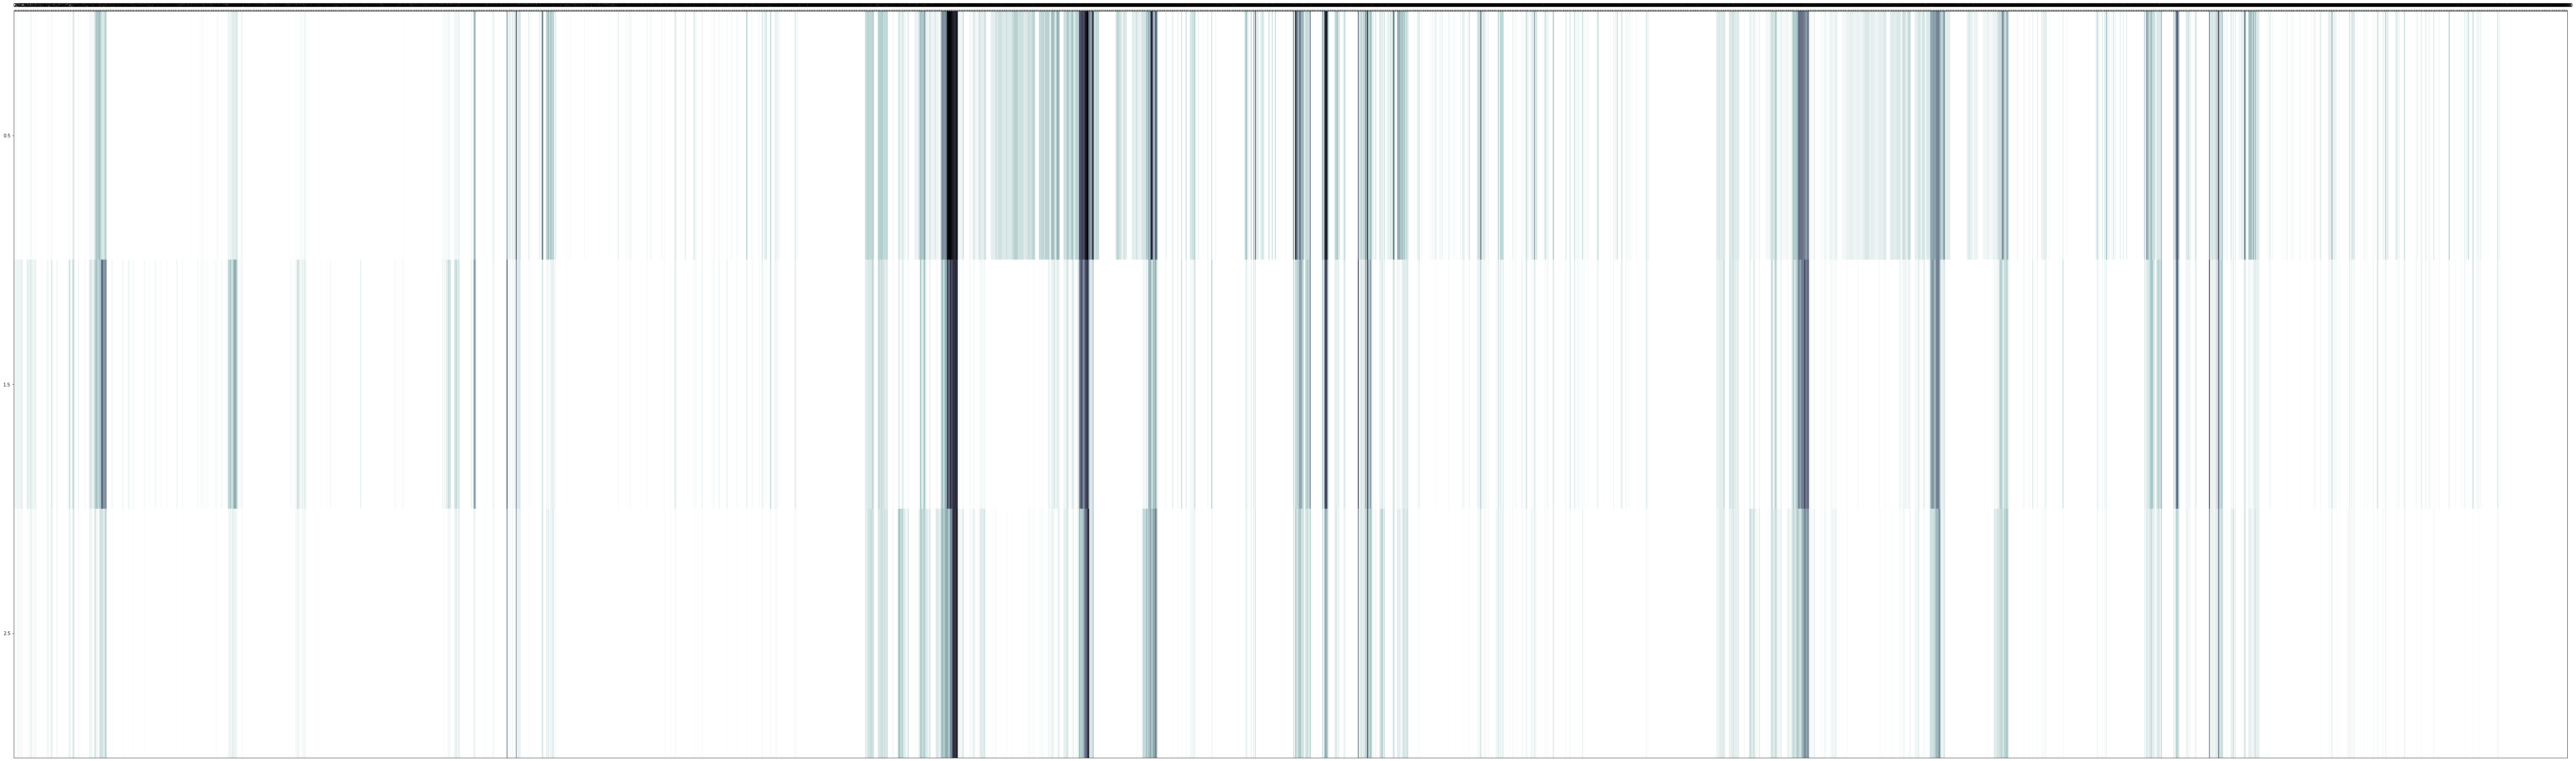

In [24]:
fig, ax = make_heatmap(cosine_to_plot)
plt.show()

In [25]:
# now find the distances of injections between the identified experiments
cosine_exp_ids = np.array(row_labels)[np.array(cosine_sorted)<0.2]


In [26]:
cosine_injs=[]
cosine_inj_structs=[]
for exp_id in cosine_exp_ids:
    cosine_injs.append([all_experiments.loc[exp_id]['injection_x'],all_experiments.loc[exp_id]['injection_y'],all_experiments.loc[exp_id]['injection_z']])
    cosine_inj_structs.append(all_experiments.loc[exp_id]['injection_structures'])

## working 20210809 on vects from cm2

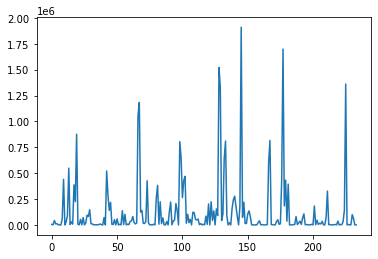

In [27]:
tst = np.load('/home/emilyjanedennis/Desktop/segmented_csvs/j316_642_vector.npy')
plt.plot(tst)

# currently unused

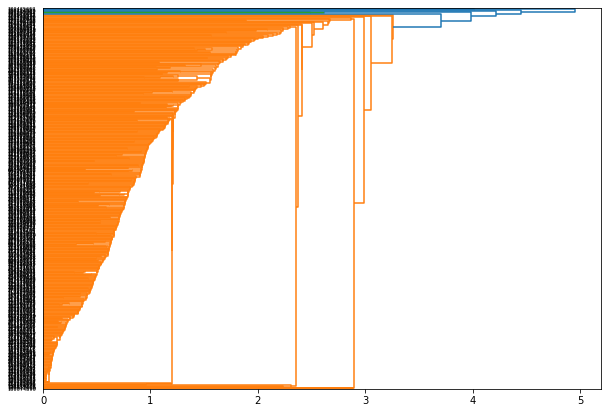

In [30]:
# https://flothesof.github.io/k-means-numpy.html
# https://jakevdp.github.io/PythonDataScienceHandbook/05.11-k-means.html
# https://scikit-learn.org/stable/modules/clustering.html#k-means

## CURRENTLY NOT USED!!

# plot dendrogram
plt.figure(figsize=(10,7))
dendrogram(linked,
          orientation='right',
          labels=row_labels,
          distance_sort='descending')
plt.show()

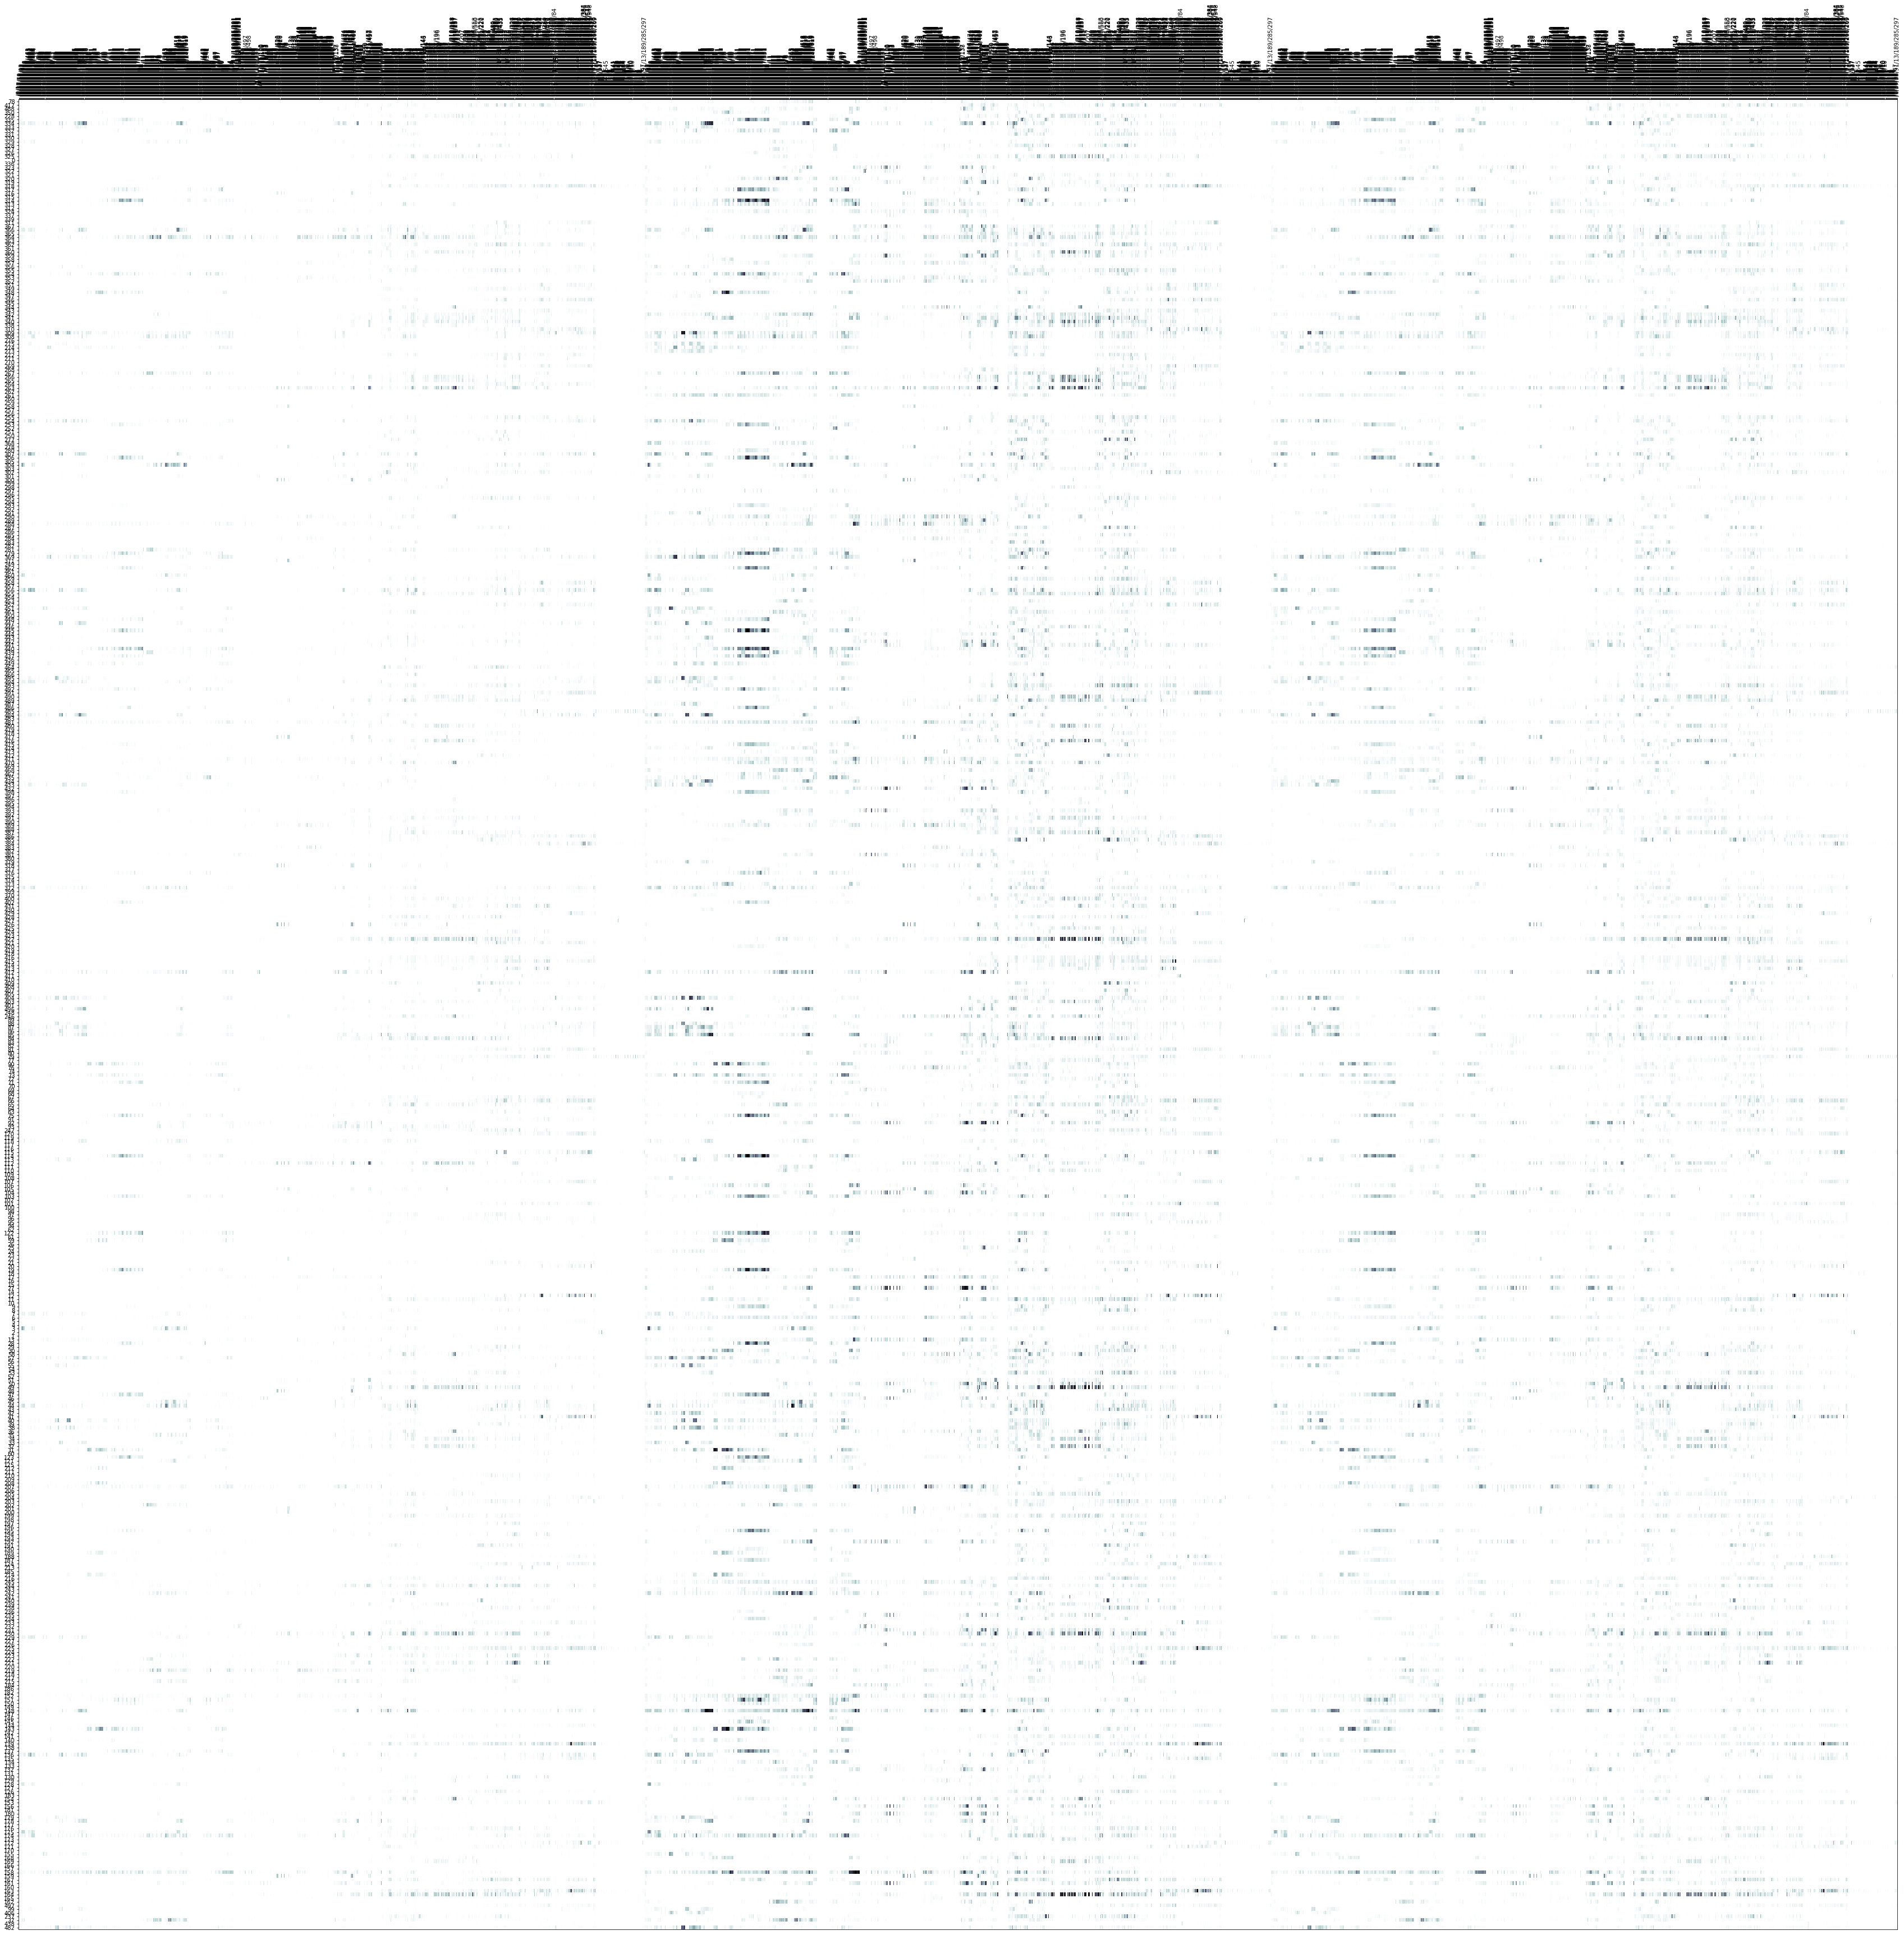

In [32]:
# https://joernhees.de/blog/2015/08/26/scipy-hierarchical-clustering-and-dendrogram-tutorial/

max_d = 1.5
clusters = fcluster(Z, max_d, criterion='distance')
clusters[clusters!=29]


k=10
clusters=fcluster(Z, k, criterion='maxclust')

data = {'row_label':row_labels,
       'cluster':clusters}

df = pd.DataFrame(data)
df

cluster_ids=[]
for i in row_labels:
    cluster_ids.append(df[df.row_label==i]['cluster'].tolist()[0])

tst2 = cluster_ids.copy()
tst2.sort()

tst = cluster_ids.copy()

arr = np.argsort(tst)

subset_matrix = matrix_no_nans[arr,:]

fig, ax = plt.subplots(figsize=(60,60))
heatmap = ax.pcolor(matrix_no_nans, cmap=plt.cm.bone_r)

# put the major ticks at the middle of each cell
ax.set_xticks(np.arange(subset_matrix.shape[1])+0.5, minor=False)
ax.set_yticks(np.arange(subset_matrix.shape[0])+0.5, minor=False)

ax.set_xlim([0, subset_matrix.shape[1]])
ax.set_ylim([0, subset_matrix.shape[0]])          

# want a more natural, table-like display
ax.invert_yaxis()
ax.xaxis.tick_top()

ax.set_xticklabels(prastruct, minor=False,rotation=90)
ax.set_yticklabels(arr, minor=False)
plt.show()

## 2020.11.27

In [2]:
from allensdk.core.mouse_connectivity_cache import MouseConnectivityCache

In [28]:
template, template_info = mcc.get_template_volume()
annot, annot_info = mcc.get_annotation_volume()

print(pd_info)
print(pd.shape, template.shape, annot.shape)

OrderedDict([('type', 'double'), ('dimension', 3), ('space', 'left-posterior-superior'), ('sizes', array([528, 320, 456])), ('space directions', array([[25.,  0.,  0.],
       [ 0., 25.,  0.],
       [ 0.,  0., 25.]])), ('kinds', ['domain', 'domain', 'domain']), ('endian', 'little'), ('encoding', 'gzip'), ('space origin', array([0., 0., 0.]))])
(528, 320, 456) (528, 320, 456) (528, 320, 456)


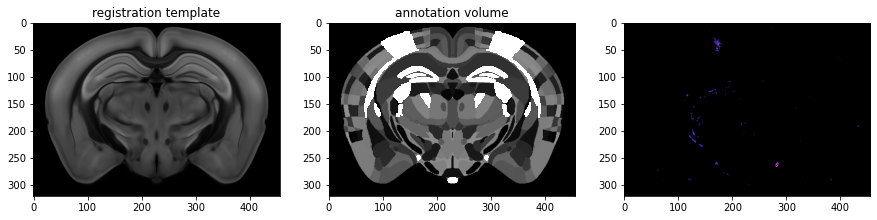

In [121]:
# Look at a slice from the average template and annotation volumes

# pick a slice to show
slice_idx = 300

f, ccf_axes = plt.subplots(1, 3, figsize=(15, 6))

ccf_axes[0].imshow(template[slice_idx,:,:], cmap='gray', aspect='equal', vmin=template.min(), vmax=template.max())
ccf_axes[0].set_title("registration template")

ccf_axes[1].imshow(annot[slice_idx,:,:], cmap='gray', aspect='equal', vmin=0, vmax=2000)
ccf_axes[1].set_title("annotation volume")

ccf_axes[2].imshow(pd[slice_idx,:,:],cmap='CMRmap',aspect='equal')

plt.show()

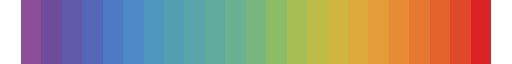

In [61]:
colors = [[255,255,255],[140,78,153],[111,76,155],[96,89,169],[85,104,184],[78,121,197],[77,138,198],[78,150,188],[84,158,179],[89,165,169],[96,171,158],[105,177,144],[119,183,125],[140,188,104],[166,190,84],[190,188,72],[209,181,65],[221,170,60],[228,156,57],[231,140,53],[230,121,50],[228,99,45],[223,72,40],[218,34,34],[255,255,255]]
cell_rainbow = ListedColormap(np.divide(colors,255), name='cell_rainbow', N=None)
cell_rainbow